In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import meerkat as mk
import numpy as np
import torch.nn as nn
import torch
import seaborn as sns
from domino.slices.train import train_model

/home/sabri/code/meerkat/meerkat/nn/__init__.py:7: ExperimentalWarning: The `meerkat.nn` module is experimental and has limited test coverage. Proceed with caution.
  warnings.warn(


In [28]:
run_id = 4689
dataset_dp = train_model.inp(run_id)["dp"].load()
model = train_model.get_artifacts("best_chkpt", run_id)["model"]

In [29]:
test_dp = dataset_dp.lz[dataset_dp["split"] == "test"].lz[:5_000]

In [30]:
from domino.vision import score
score_dp = score(
    model=model.load(), 
    dp=test_dp, 
    input_column="input",
    batch_size=128
)

/home/common/envs/conda/envs/domino/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [31]:
score_dp["loss"] = nn.functional.cross_entropy(score_dp["output"].data, torch.tensor(score_dp["target"].data), reduction="none")

In [32]:
score_dp["prob"] = score_dp["output"].probabilities().data[:, -1]
from sklearn.metrics import roc_auc_score
print("Overall AUROC: {}".format(
    roc_auc_score(score_dp["target"], score_dp["prob"])
))
print("Overall AUROC with correlate: {}".format(
    roc_auc_score(score_dp["correlate"], score_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] == score_dp["correlate"]]
print("AUROC where correlation holds: {}".format(
    roc_auc_score(curr_dp["target"], curr_dp["prob"])
))

curr_dp = score_dp.lz[score_dp["target"] != score_dp["correlate"]]
print("AUROC where correlation does not hold: {}".format(
    roc_auc_score(curr_dp["target"], curr_dp["prob"])
))

Overall AUROC: 0.9479772651287195
Overall AUROC with correlate: 0.880653043878599
AUROC where correlation holds: 0.9976526184115022
AUROC where correlation does not hold: 0.75


In [33]:
from domino.clip import embed_images
score_dp = embed_images(dp=score_dp, img_column="object_image")

In [34]:
from domino.clip import embed_words
#words_dp = embed_words(words_dp).load()
words_dp = embed_words.out(4508).load()
words_dp = words_dp.lz[:int(1e4)]

In [36]:
dp = score_dp
attr_emb = dp.lz[(dp["prob"].numpy() > 0.5)]["emb"].data.numpy().mean(axis=0)
#attr_emb = dp.lz[dp["correlate"]== 1]["emb"].data.numpy().mean(axis=0)
ref_emb = dp.lz[dp["target"] == 1]["emb"].data.numpy().mean(axis=0)

scores = np.dot( 
    words_dp["emb"].data.numpy(),   
    (attr_emb - ref_emb) 
)
words_dp.lz[(-scores).argsort()[0:20]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,sleeve,10944,7786,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
1,hurling,24580,5028,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
2,injury,130116,1695,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
3,jubilee,18960,5839,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
4,column,68853,2656,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
5,injured,89609,2222,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
6,replica,14700,6693,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
7,reddish,11652,7549,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
8,sporting,54275,3088,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
9,telescope,20719,5560,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))


In [ ]:
nn.functional.cross_entropy(dp[""])

,object_image (LambdaColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),prob (TensorColumn)
0,,0,0,tensor(0.2052)
1,,0,0,tensor(0.3483)
2,,0,0,tensor(0.2647)
3,,0,0,tensor(0.2150)
4,,0,0,tensor(0.2486)
5,,0,0,tensor(0.2168)
6,,0,0,tensor(0.3931)
7,,0,0,tensor(0.2848)
8,,0,0,tensor(0.2046)
9,,0,0,tensor(0.2021)

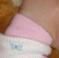
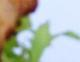
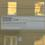
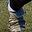
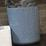

In [15]:
mk.config.DisplayOptions.max_rows = 100
dp.lz[(dp["prob"].numpy() > 0.2) * (dp["target"] == 0)][["object_image", "target", "correlate", "prob"]]

In [96]:
(score_dp["prob"].data.numpy() > 0.001).sum()

99

In [88]:
len(score_dp)

4600

In [54]:
torch.tensor(score_dp["emb"].data, device=0)

<ipython-input-54-02fae554fc7e>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(score_dp["emb"].data, device=0)


tensor([[ 0.0390,  0.2744, -0.3843,  ...,  0.3462, -0.1584, -0.1855],
        [ 0.0710,  0.6484, -0.0450,  ...,  1.1016, -0.2976,  0.0517],
        [ 0.1804, -0.1355, -0.5532,  ...,  1.0703, -0.2042, -0.0511],
        ...,
        [ 0.3059,  0.0224, -0.5381,  ...,  0.7358, -0.0623, -0.3462],
        [ 0.0543,  0.0970, -0.0390,  ...,  0.7334,  0.0433, -0.0353],
        [-0.3921,  0.0475,  0.1824,  ...,  1.1406,  0.6475, -0.1752]],
       device='cuda:0', dtype=torch.float16)

In [59]:
from domino.sdm import SpotlightSDM
sdm = SpotlightSDM(config={"emb": "emb"})

sdm.fit(score_dp)

ValueError: only one element tensors can be converted to Python scalars

In [67]:
dp = score_dp
attr_emb = dp.lz[(dp["cluster"] == 2)]["emb"].data.numpy().mean(axis=0)
ref_emb = dp["emb"].data.numpy().mean(axis=0)

scores = np.dot( 
    words_dp["emb"].data.numpy(),   
    (attr_emb - ref_emb) 
)
words_dp.lz[(-scores).argsort()[0:10]]

,word (PandasSeriesColumn),frequency (PandasSeriesColumn),index (PandasSeriesColumn),tokens (LambdaColumn),emb (TensorColumn)
0,junior,215680,1092,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
1,umpire,9764,8277,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
2,opponent,46804,3442,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
3,determination,19996,5656,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
4,younger,143054,1567,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
5,coaching,74848,2522,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
6,coach,384927,626,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
7,kemp,8280,8963,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
8,concentration,58600,2941,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))
9,sloan,8062,9074,LambdaCell(fn=),torch.Tensor(shape=torch.Size([512]))


,image_id (NumpyArrayColumn),height (NumpyArrayColumn),url (PandasSeriesColumn),width (NumpyArrayColumn),index (PandasSeriesColumn),local_path (PandasSeriesColumn),image (ImageColumn),h (NumpyArrayColumn),name (PandasSeriesColumn),object_id (NumpyArrayColumn),syn_name (PandasSeriesColumn),w (NumpyArrayColumn),x (NumpyArrayColumn),y (NumpyArrayColumn),object_image (LambdaColumn),target (NumpyArrayColumn),correlate (NumpyArrayColumn),input (LambdaColumn),id (NumpyArrayColumn),split (PandasSeriesColumn),output (ClassificationOutputColumn),prob (TensorColumn),__embed_images_input__ (LambdaColumn),emb (TensorColumn),cluster (NumpyArrayColumn)
0,2398606.0,375.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2398606.jpg,500.0,697488,/home/common/datasets/visual-genome/VG_100K_2/2398606.jpg,,84.0,table,662316.0,table.n.02,499.0,1.0,1.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",662316.0,test,torch.Tensor(shape=torch.Size([2])),tensor(2.6015e-05),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
1,2375491.0,400.0,https://cs.stanford.edu/people/rak248/VG_100K/2375491.jpg,500.0,1268425,/home/common/datasets/visual-genome/VG_100K/2375491.jpg,,26.0,wire,581949.0,wire.n.01,338.0,0.0,154.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",581949.0,test,torch.Tensor(shape=torch.Size([2])),tensor(9.7957e-06),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
2,2377825.0,333.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2377825.jpg,500.0,1180509,/home/common/datasets/visual-genome/VG_100K_2/2377825.jpg,,42.0,street sign,3177814.0,street_sign.n.01,55.0,386.0,86.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",3177814.0,test,torch.Tensor(shape=torch.Size([2])),tensor(0.0001),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
3,2389799.0,500.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2389799.jpg,375.0,896878,/home/common/datasets/visual-genome/VG_100K_2/2389799.jpg,,39.0,sign,1257068.0,sign.n.02,145.0,127.0,185.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",1257068.0,test,torch.Tensor(shape=torch.Size([2])),tensor(0.0004),"LambdaCell(fn=Compose( Resize(size=224, interpolation=bicubic) CenterCrop(size=(224, 224)) . at 0x7f6934578550> ToTensor() Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)) ))",torch.Tensor(shape=torch.Size([512])),2.0
4,2405035.0,357.0,https://cs.stanford.edu/people/rak248/VG_100K_2/2405035.jpg,500.0,537849,/home/common/datasets/visual-genome/VG_100K_2/2405035.jpg,,150.0,wall,1111083.0,wall.n.01,402.0,94.0,205.0,,0.0,0.0,"LambdaCell(fn=Compose( Resize(size=256, interpolation=bilinear) CenterCrop(size=(224, 224)) ToTensor() Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) ))",1111083.0,test,torch.Tensor(shape=torch.Size([2])),tensor(2.3699e-05),"LambdaCell(fn=Compose( Resize(size=224, interpolation
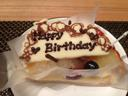
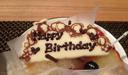
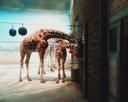
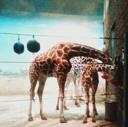
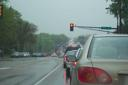
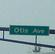
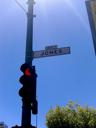
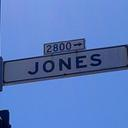
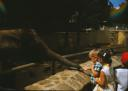
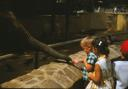
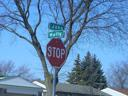
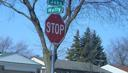
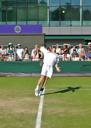
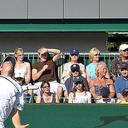
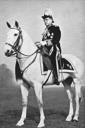
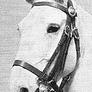
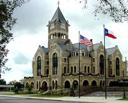
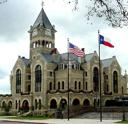
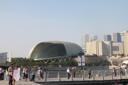
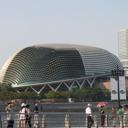

In [68]:
dp.lz[dp["cluster"] == 2]